In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

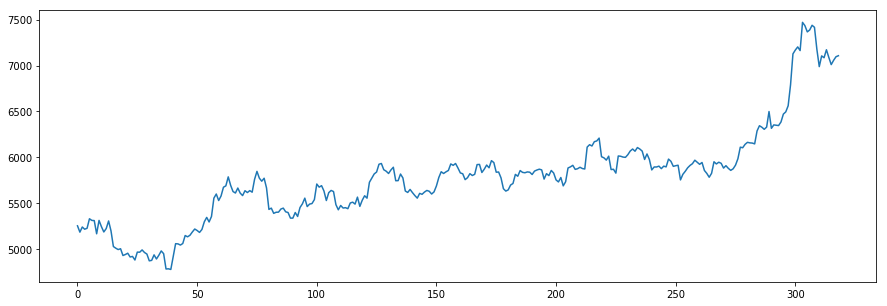

In [3]:
data = pd.read_csv(open(r'E:\Users\OneDrive\桌面\word\futures_data\AG9999.XSGE.csv'))
stock_df=data[['open','high','low','close','volume','open_interest','date']]
stock_df.index=data['date']
stock_df=stock_df['close']['2023/1/9':]
plt.figure(figsize=(15, 5))
plt.plot(stock_df.values)
plt.show()

In [4]:
# 创建数据集
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length, future_length):
        self.data = data
        self.sequence_length = sequence_length
        self.future_length = future_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        if idx + self.sequence_length + self.future_length <= len(self.data):
            labels = torch.tensor(self.data[idx+self.sequence_length:idx+self.sequence_length+self.future_length], dtype=torch.float)
        else:
            last_day_data = torch.tensor([data[-1]], dtype=torch.float)
            labels = torch.tensor(self.data[idx+self.sequence_length:], dtype=torch.float)
            for i in range(future_length-len(labels)):
                labels = torch.cat((labels,last_day_data),0)
        return (
            torch.tensor(self.data[idx:idx+self.sequence_length], dtype=torch.float),
            labels.reshape(-1, 1).squeeze(1)
        )
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(stock_df.values.reshape(-1,1))   # 归一化 -1~1

sequence_length = 50   # 训练步长
future_length = 2      # 预测步长|训练步长
batch_size = 16
train_size = int(len(data) * 0.80)
train_data = data[:train_size]
test_data = data[train_size:]
# 创建数据加载器
train_dataset = StockDataset(train_data, sequence_length, future_length)
test_dataset = StockDataset(test_data, sequence_length, future_length)
data_dataset = StockDataset(data, sequence_length, future_length)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data_loader = torch.utils.data.DataLoader(data_dataset, batch_size=batch_size, shuffle=True)
data_loader_F = torch.utils.data.DataLoader(data_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for i, (inputs, labels) in enumerate(test_loader):
    print(labels)

tensor([[0.9228, 0.9384],
        [0.9384, 0.9763],
        [0.9763, 0.9599],
        [0.9599, 0.7819],
        [0.7819, 0.6417],
        [0.6417, 0.7285],
        [0.7285, 0.7136],
        [0.7136, 0.7782],
        [0.7782, 0.7159],
        [0.7159, 0.6580],
        [0.6580, 0.6929],
        [0.6929, 0.7218],
        [0.7218, 0.7300],
        [0.7300, 0.7300]])


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers     # lstm层数
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化h0，c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 隐层结构
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 细胞结构

        out, _ = self.lstm(x, (h0, c0))   # 返回所有LSTM最后一层每一个时间步的输出h，每一层最后一个时间步的隐状态h_n和细胞状态c_n（丢掉）
        out = self.fc(out[:, -1, :]) # 最后一个时间步的数据(batch_size, seq_len, hidden_size)
        return out

Epoch [50/500], Loss: 0.006981451888210499
Epoch [100/500], Loss: 0.0053721584487133305
Epoch [150/500], Loss: 0.005626265899851345
Epoch [200/500], Loss: 0.00460890017879697
Epoch [250/500], Loss: 0.003158775597022703
Epoch [300/500], Loss: 0.0015701913239004521
Epoch [350/500], Loss: 0.0010612146579660475
Epoch [400/500], Loss: 0.0010091678122989833
Epoch [450/500], Loss: 0.0008111761551565275
Epoch [500/500], Loss: 0.0005087734697064242


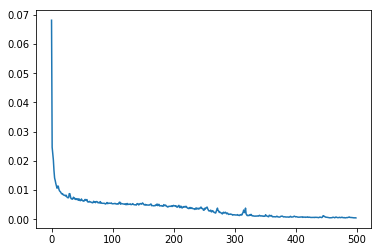

In [8]:
# 训练模型
model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=future_length) # 输入，隐藏，LSTM 堆叠层数，输出
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses=[]
num_epochs = 500
for epoch in range(num_epochs):
    model.train()   # 训练模式
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    losses.append(epoch_loss)
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')
plt.plot(losses)
plt.show()

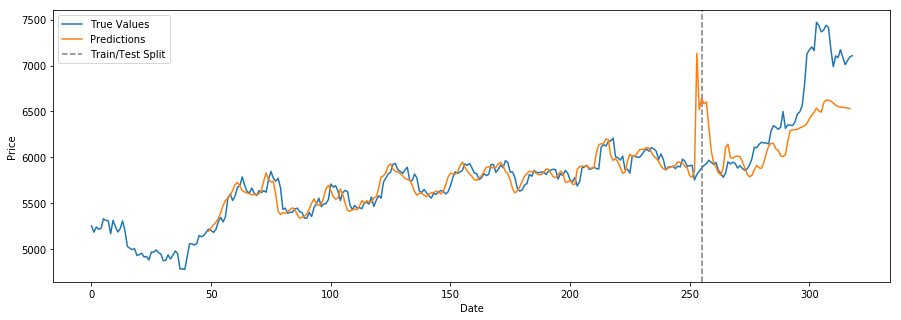

In [9]:
# 测试集
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in data_loader_F:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predictions = np.concatenate(predictions, axis=0)
predictions = scaler.inverse_transform(predictions)
if predictions.shape[1] != 1:
    predictions = predictions[:,1]
# 可视化
plt.figure(figsize=(15, 5))
test_data_normalized = data.reshape(-1, 1)  # 还原数据
test_data_original = scaler.inverse_transform(test_data_normalized)
x_shifted = range(sequence_length-1, sequence_length + len(predictions)-1)
plt.plot(test_data_original, label='True Values')
plt.plot(x_shifted, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.axvline(x=len(stock_df) - len(test_data), color='gray', linestyle='--', label='Train/Test Split')  # 分割线
plt.legend()
plt.show()

未来1日预测价格6465.98:
未来2日预测价格6315.68:


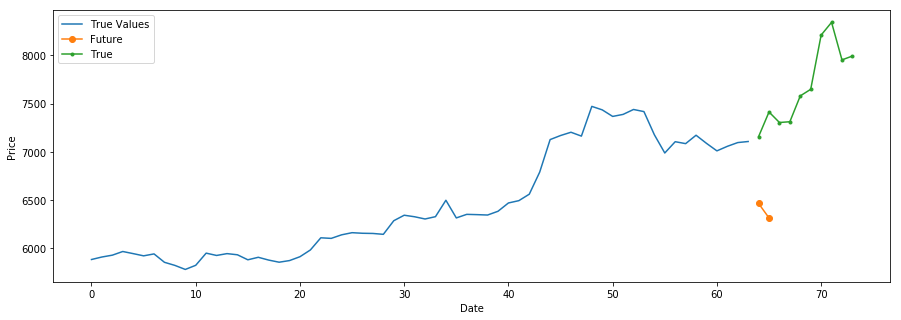

In [10]:
# 未来预测
model.eval()  # 评估模型
future_close = []
last_data = stock_df.iloc[-1]

last_data = torch.tensor(last_data,dtype=torch.float).reshape(1, -1)
last_data=torch.unsqueeze(input=last_data, dim=1)
with torch.no_grad():  # 在预测阶段不需要计算梯度
    last_data = model(last_data)
    last_data = last_data.reshape(-1, 1)  # 还原数据
    last_data = scaler.inverse_transform(last_data)

for i,price in enumerate(last_data):
    print("未来{}日预测价格{:.2f}:".format(i+1,float(price)))
    future_close.append(price)

true_close = [7159,7414,7305,7313,7581,7649,8211,8343,7954,7994]
# 可视化
plt.figure(figsize=(15, 5))
x=len(stock_df) - len(test_data)
data_normalized = data[x:].reshape(-1, 1)  # 还原数据
data_original = scaler.inverse_transform(data_normalized)
plt.plot(data_original, label='True Values')
x_shifted1 = range(len(data_original),len(data_original) + len(future_close))
plt.plot(x_shifted1,future_close, label='Future', marker='o')
x_shifted2 = range(len(data_original),len(data_original) + len(true_close))
plt.plot(x_shifted2,true_close, label='True', marker='.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()